## Train poisson regression model

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns

### Read in feature set and select x and y

In [15]:
# Read in data
feature_set_2021 = pd.read_csv('../data/stats/past_seasons/combined_per60_roll15_2021.csv')
feature_set_2022 = pd.read_csv('../data/stats/past_seasons/combined_per60_roll15_2022.csv')
feature_set_2023 = pd.read_csv('../data/stats/past_seasons/combined_per60_roll15_2023.csv')

feature_set_all = pd.concat([feature_set_2021, feature_set_2022, feature_set_2023], axis=0).reset_index(drop = True)
print(feature_set_all.info())
feature_set_all.dropna(inplace=True) # This is technically wrong

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125637 entries, 0 to 125636
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   s_player_id          125637 non-null  object 
 1   s_name               125637 non-null  object 
 2   s_age                125637 non-null  int64  
 3   season               125637 non-null  int64  
 4   s_game_num           125637 non-null  int64  
 5   date                 125637 non-null  object 
 6   s_team               125637 non-null  object 
 7   s_opponent           125637 non-null  object 
 8   s_home_away_status   125637 non-null  int64  
 9   s_result             125637 non-null  object 
 10  G                    125637 non-null  int64  
 11  s_n_completed_games  125637 non-null  int64  
 12  G_60                 122771 non-null  float64
 13  A_60                 122771 non-null  float64
 14  P_60                 122771 non-null  float64
 15  rating_60        

In [16]:
feature_set_all.columns

Index(['s_player_id', 's_name', 's_age', 'season', 's_game_num', 'date',
       's_team', 's_opponent', 's_home_away_status', 's_result', 'G',
       's_n_completed_games', 'G_60', 'A_60', 'P_60', 'rating_60', 'PIM_60',
       'EVG_60', 'PPG_60', 'SHG_60', 'GWG_60', 'EVA_60', 'PPA_60', 'SHA_60',
       'S_60', 'shifts_60', 'HIT_60', 'BLK_60', 'FOW_60', 'FOL_60',
       's_avg_TOI', 'g_player_id', 'g_name', 'g_age', 'g_game_num', 'decision',
       'g_n_completed_games', 'GA_60', 'SA_60', 'SV_60', 'total_shutout',
       'SV_perc', 'g_avg_TOI'],
      dtype='object')

In [17]:
x_cols = ['s_home_away_status', 'G_60', 'A_60', 'P_60', 'rating_60', 'PIM_60','EVG_60', 'PPG_60', 'SHG_60', 'GWG_60', 'EVA_60', 'PPA_60', 'SHA_60', 'S_60',
    'shifts_60', 'HIT_60', 'BLK_60', 'FOW_60', 'FOL_60', 's_avg_TOI', 'GA_60', 'SA_60', 'SV_60', 'total_shutout', 'SV_perc']

### Split data into train/test

In [18]:
train, test = train_test_split(feature_set_all, test_size=0.25, random_state=114)

In [19]:
x_train = train[x_cols]
y_train = train['G']

x_test = test[x_cols]
y_test = test['G']

In [20]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87909 entries, 42942 to 95236
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   s_home_away_status  87909 non-null  int64  
 1   G_60                87909 non-null  float64
 2   A_60                87909 non-null  float64
 3   P_60                87909 non-null  float64
 4   rating_60           87909 non-null  float64
 5   PIM_60              87909 non-null  float64
 6   EVG_60              87909 non-null  float64
 7   PPG_60              87909 non-null  float64
 8   SHG_60              87909 non-null  float64
 9   GWG_60              87909 non-null  float64
 10  EVA_60              87909 non-null  float64
 11  PPA_60              87909 non-null  float64
 12  SHA_60              87909 non-null  float64
 13  S_60                87909 non-null  float64
 14  shifts_60           87909 non-null  float64
 15  HIT_60              87909 non-null  float64
 16  BLK_6

In [21]:
print(y_train.value_counts())
print(y_test.value_counts())

G
0    74607
1    11823
2     1303
3      167
4        8
5        1
Name: count, dtype: int64
G
0    24970
1     3864
2      410
3       57
4        2
5        1
Name: count, dtype: int64


### Establish baseline prediction

In [10]:
#avg_G_game_test = test.groupby(['s_player_id', 'season'])['G', 's_TOI'].sum().reset_index()
#avg_G_game_test.columns = ['s_player_id', 'season', 'avg_G_game']
#baseline_pred = pd.merge(feature_set_all, avg_G_game_test, on = ['s_player_id', 'season'])[['G', 'avg_G_game']]
#avg_G_game_test

In [11]:
#mean_squared_error(baseline_pred['G'], baseline_pred['avg_G_game'])

### One hot encoding for home/away status

In [22]:
ohe = OneHotEncoder()
transformed_train = ohe.fit_transform(x_train[['s_home_away_status']])
enc_home_away_train = pd.DataFrame(transformed_train.toarray())
enc_home_away_train.columns = ['s_away', 's_home']


transformed_test = ohe.transform(x_test[['s_home_away_status']])
enc_home_away_test = pd.DataFrame(transformed_test.toarray())
enc_home_away_test.columns = ['s_away', 's_home']

In [23]:
x_train.reset_index(inplace=True, drop = True)
x_train = pd.concat([x_train, enc_home_away_train], axis = 1)
x_train.drop(columns = 's_home_away_status')

x_test.reset_index(inplace=True, drop = True)
x_test = pd.concat([x_test, enc_home_away_test], axis = 1)
x_test.drop(columns = 's_home_away_status')

,G_60,A_60,P_60,rating_60,PIM_60,EVG_60,PPG_60,SHG_60,GWG_60,EVA_60,...,FOW_60,FOL_60,s_avg_TOI,GA_60,SA_60,SV_60,total_shutout,SV_perc,s_away,s_home
0,0.247831,0.495663,0.743494,-0.743494,0.991326,0.247831,0.000000,0.0,0.000000,0.495663,...,0.000000,0.000000,16.140000,4.232666,40.210327,35.977661,0.0,0.894737,1.0,0.0
1,0.000000,1.665587,1.665587,-1.665587,0.000000,0.000000,0.000000,0.0,0.000000,1.665587,...,20.986398,21.985750,12.007778,2.484018,32.511416,30.027397,0.0,0.923596,1.0,0.0
2,0.587563,0.587563,1.175126,0.000000,6.463196,0.587563,0.000000,0.0,0.000000,0.587563,...,30.553289,26.440346,13.615556,3.584765,34.055265,30.470500,0.0,0.894737,0.0,1.0
3,0.000000,1.117376,1.117376,0.558688,1.862294,0.000000,0.000000,0.0,0.000000,1.117376,...,0.000000,0.000000,21.478889,2.400679,31.354322,28.953643,2.0,0.923434,1.0,0.0
4,1.041486,1.666377,2.707863,0.624892,0.000000,1.041486,0.000000,0.0,0.208297,0.833189,...,1.249783,0.416594,19.203333,2.655602,31.136929,28.481328,0.0,0.914712,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29299,0.249619,0.998475,1.248093,-0.249619,1.497712,0.000000,0.249619,0.0,0.000000,0.748856,...,4.992373,6.240466,16.024444,3.451818,34.518184,31.066365,0.0,0.900000,0.0,1.0
29300,0.536033,0.268017,0.804050,0.000000,0.000000,0.536033,0.000000,0.0,0.000000,0.268017,...,0.000000,0.000000,18.655556,3.687151,32.178771,28.491620,0.0,0.885417,0.0,1.0
29301,0.000000,0.340619,0.340619,0.000000,0.681238,0.000000,0.000000,0.0,0.000000,0.340619,...,0.000000,0.000000,11.743333,3.260467,35.272323,32.011856,0.0,0.907563,1.0,0.0
29302,6.106870,6.106870,12.213740,6.106870,0.000000,0.000000,6.106870,0.0,3.053435,3.053435,...,36.641221,27.480916,19.650000,3.000938,35.261019,32.260081,0.0,0.914894,0.0,1.0


In [24]:
subset = ['P_60', 'G_60', 'S_60', 'PPG_60', 'PPA_60', 'BLK_60', 's_avg_TOI']

x_train2 = x_train.loc[:, subset]
x_test2 = x_test.loc[:, subset]

### Poisson regression

In [25]:
pois_reg = PoissonRegressor(max_iter=1000)

In [26]:
pois_reg.fit(x_train2, y_train)

PoissonRegressor(max_iter=1000)

In [27]:
preds = pois_reg.predict(x_test2)

In [28]:
preds

array([0.10218557, 0.15497366, 0.11944017, ..., 0.10225986, 0.63012658,
       0.11393354])

In [29]:
mse = mean_squared_error(y_test, preds)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.17171149110130296


<Axes: ylabel='Count'>

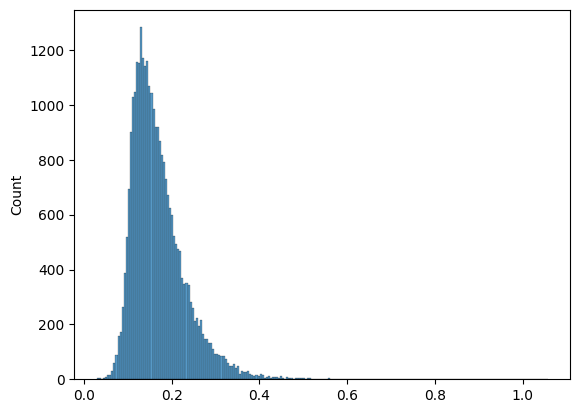

In [30]:
sns.histplot(x = preds)

In [31]:
len(preds)

29304

### RF

In [32]:
param_grid = {
    'n_estimators': [10, 50, 100, 250],
    'max_depth': [None, 5, 10]#,
    #'max_features': ['sqrt', 'log2']
}

# Create the random forest regressor model
rf = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)

# Fit the model to the data
grid_search.fit(x_train2, y_train)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 5, 'n_estimators': 250}
Best score:  0.06359855297634806


In [4]:
rf_best = RandomForestRegressor(max_depth=5, n_estimators=50)

rf_best.fit(x_train2, y_train)

preds = rf_best.predict(x_test2)

NameError: name 'x_train2' is not defined

In [58]:
rf_best.score(x_test2, y_test)

0.061698088462337264

In [59]:
print(mean_squared_error(y_test, preds))

0.1685935071845463


In [1]:
rf_best.feature_importances_

NameError: name 'rf_best' is not defined